--- Select a Company to Analyze ---
- Apple
- Microsoft
- Google
- Amazon
- Nvidia
- Tesla
- Meta
- Berkshire
- Eli Lilly
- Visa
-----------------------------------
Enter the name of the company: Apple


/tmp/ipython-input-1253489976.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed

Fetching data for Apple (AAPL)...
--- Starting project for ticker: AAPL ---
--- Data downloaded and signals generated ---
Price            close        high         low        open    volume  \
Date                                                                   
2023-12-22  191.974670  193.769472  191.349955  193.541392  37149600   
2023-12-26  191.429291  192.262235  191.211137  191.984587  28919300   
2023-12-27  191.528458  191.875525  189.485754  190.874010  48087700   
2023-12-28  191.954865  193.025800  191.548303  192.510161  34049900   
2023-12-29  190.913651  192.767946  190.120364  192.272144  42672100   

Price            sma_9  signal  
Date                            
2023-12-22  194.386475       0  
2023-12-26  194.203576       0  
2023-12-27  193.673618       0  
2023-12-28  193.174515       0  
2023-12-29  192.619217       0  
--- Plotting historical data for AAPL ---


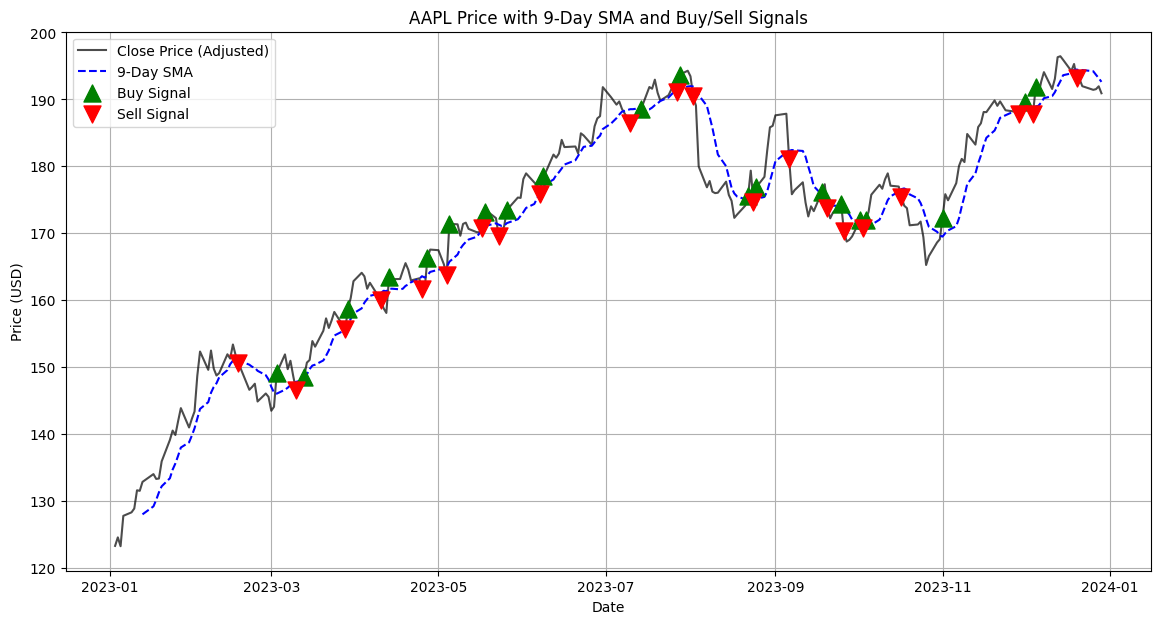

--- Preparing data for LSTM model ---
Data shape for LSTM: (190, 60, 1)
--- Building and training LSTM model ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- Model training complete ---
--- Starting 7-day future prediction ---
--- 7-Day Prediction Complete ---
[[192.0145 ]
 [191.84589]
 [191.69858]
 [191.5671 ]
 [191.44746]
 [191.33682]
 [191.23322]]
--- Plotting 7-day prediction ---


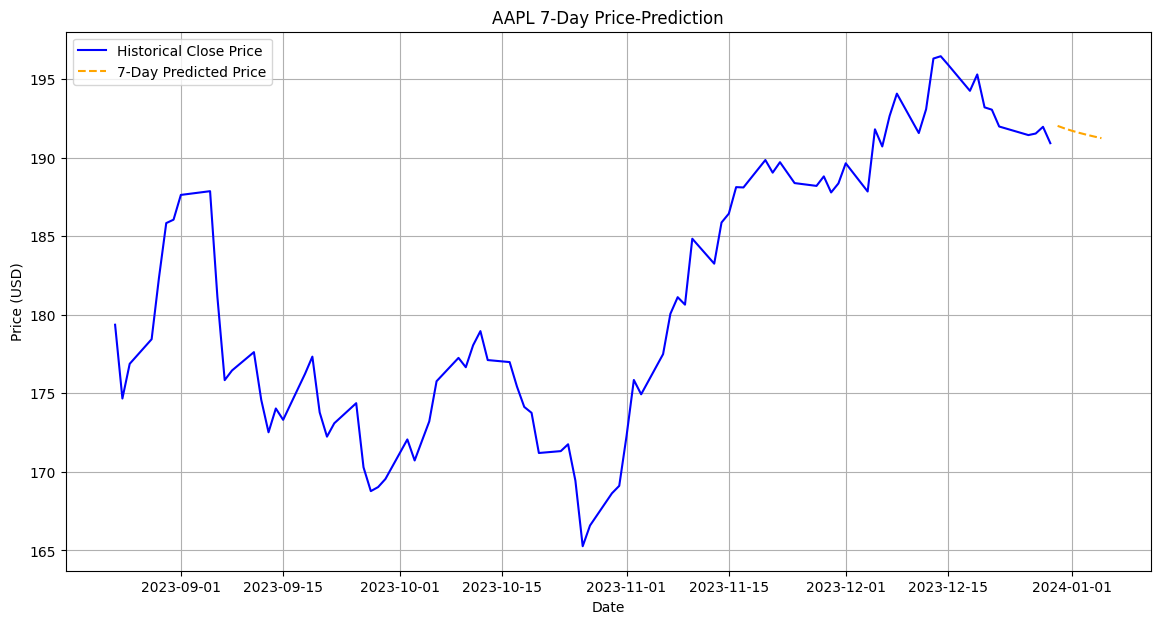

--- Project Complete ---


In [11]:
!pip install yfinance pandas numpy scikit-learn tensorflow matplotlib

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import sys

company_map = {
    'apple': 'AAPL',
    'microsoft': 'MSFT',
    'google': 'GOOGL',
    'amazon': 'AMZN',
    'nvidia': 'NVDA',
    'tesla': 'TSLA',
    'meta': 'META',
    'berkshire': 'BRK-B',
    'eli lilly': 'LLY',
    'visa': 'V'
}

print("--- Select a Company to Analyze ---")
for company in company_map:
    print(f"- {company.title()}")
print("-----------------------------------")

user_input = input("Enter the name of the company: ").lower()

if user_input in company_map:
    STOCK_TICKER = company_map[user_input]
    print(f"Fetching data for {user_input.title()} ({STOCK_TICKER})...")
else:
    print(f"Error: '{user_input}' is not a valid option. Please restart and try again.")
    sys.exit()

START_DATE = '2023-01-01'
END_DATE = '2024-01-01'
SMA_PERIOD = 9
LOOKBACK_DAYS = 60

print(f"--- Starting project for ticker: {STOCK_TICKER} ---")

df = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df.columns = df.columns.str.lower()

if df.empty:
    print(f"No data found for {STOCK_TICKER}.")
    sys.exit()

PRICE_COL = 'close'

sma_col_name = f'sma_{SMA_PERIOD}'
df[sma_col_name] = df[PRICE_COL].rolling(window=SMA_PERIOD).mean()

df['signal'] = 0

buy_condition_1 = df.eval(f"{PRICE_COL} > {sma_col_name}").fillna(False)
buy_condition_2 = df.eval(f"{PRICE_COL}.shift(1) < {sma_col_name}.shift(1)").fillna(False)

sell_condition_1 = df.eval(f"{PRICE_COL} < {sma_col_name}").fillna(False)
sell_condition_2 = df.eval(f"{PRICE_COL}.shift(1) > {sma_col_name}.shift(1)").fillna(False)

df.loc[buy_condition_1 & buy_condition_2, 'signal'] = 1
df.loc[sell_condition_1 & sell_condition_2, 'signal'] = -1

buy_signals = df[df['signal'] == 1]
sell_signals = df[df['signal'] == -1]

print("--- Data downloaded and signals generated ---")
print(df.tail())

print(f"--- Plotting historical data for {STOCK_TICKER} ---")
plt.figure(figsize=(14, 7))
plt.plot(df.index, df[PRICE_COL], label='Close Price (Adjusted)', color='black', alpha=0.7)
plt.plot(df.index, df[sma_col_name], label=f'{SMA_PERIOD}-Day SMA', color='blue', linestyle='--')
plt.scatter(buy_signals.index, buy_signals[PRICE_COL], label='Buy Signal', marker='^', color='green', s=150, zorder=5)
plt.scatter(sell_signals.index, sell_signals[PRICE_COL], label='Sell Signal', marker='v', color='red', s=150, zorder=5)
plt.title(f'{STOCK_TICKER} Price with {SMA_PERIOD}-Day SMA and Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

print("--- Preparing data for LSTM model ---")
data = df.filter([PRICE_COL])
dataset = data.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data

X_train = []
y_train = []

for i in range(LOOKBACK_DAYS, len(train_data)):
    X_train.append(train_data[i-LOOKBACK_DAYS:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(f"Data shape for LSTM: {X_train.shape}")

print("--- Building and training LSTM model ---")
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=25, verbose=0)
print("--- Model training complete ---")

print("--- Starting 7-day future prediction ---")
last_60_days = scaled_data[-LOOKBACK_DAYS:]
future_predictions = []

for i in range(7):
    X_test = np.reshape(last_60_days, (1, LOOKBACK_DAYS, 1))
    pred_price = model.predict(X_test, verbose=0)
    future_predictions.append(pred_price[0, 0])
    last_60_days = np.append(last_60_days[1:], pred_price, axis=0)

predicted_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

print("--- 7-Day Prediction Complete ---")
print(predicted_prices)

print("--- Plotting 7-day prediction ---")
last_date = df.index[-1]
prediction_dates = pd.to_datetime([last_date + pd.DateOffset(days=i) for i in range(1, 8)])
historical_data = df[PRICE_COL][-90:]
plt.figure(figsize=(14, 7))
plt.plot(historical_data.index, historical_data, label='Historical Close Price', color='blue')
plt.plot(prediction_dates, predicted_prices, label='7-Day Predicted Price', color='orange', linestyle='--')
plt.title(f'{STOCK_TICKER} 7-Day Price-Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

print("--- Project Complete ---")